# RMSProp算法
:label:`sec_rmsprop`

 :numref:`sec_adagrad`中的关键问题之一，是学习率按预定时间表$\mathcal{O}(t^{-\frac{1}{2}})$显著降低。
虽然这通常适用于凸问题，但对于深度学习中遇到的非凸问题，可能并不理想。
但是，作为一个预处理器，Adagrad算法按坐标顺序的适应性是非常可取的。

 :cite:`Tieleman.Hinton.2012`建议以RMSProp算法作为将速率调度与坐标自适应学习率分离的简单修复方法。
问题在于，Adagrad算法将梯度$\mathbf{g}_t$的平方累加成状态矢量$\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$。
因此，由于缺乏规范化，没有约束力，$\mathbf{s}_t$持续增长，几乎上是在算法收敛时呈线性递增。

解决此问题的一种方法是使用$\mathbf{s}_t / t$。
对$\mathbf{g}_t$的合理分布来说，它将收敛。
遗憾的是，限制行为生效可能需要很长时间，因为该流程记住了值的完整轨迹。
另一种方法是按动量法中的方式使用泄漏平均值，即$\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$，其中参数$\gamma > 0$。
保持所有其它部分不变就产生了RMSProp算法。

## 算法

让我们详细写出这些方程式。

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

常数$\epsilon > 0$通常设置为$10^{-6}$，以确保我们不会因除以零或步长过大而受到影响。
鉴于这种扩展，我们现在可以自由控制学习率$\eta$，而不考虑基于每个坐标应用的缩放。
就泄漏平均值而言，我们可以采用与之前在动量法中适用的相同推理。
扩展$\mathbf{s}_t$定义可获得

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
$$

同之前在 :numref:`sec_momentum`小节一样，我们使用$1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$。
因此，权重总和标准化为$1$且观测值的半衰期为$\gamma^{-1}$。
让我们图像化各种数值的$\gamma$在过去40个时间步长的权重。


In [7]:
import math
import torch
# from d2l import torch as d2l

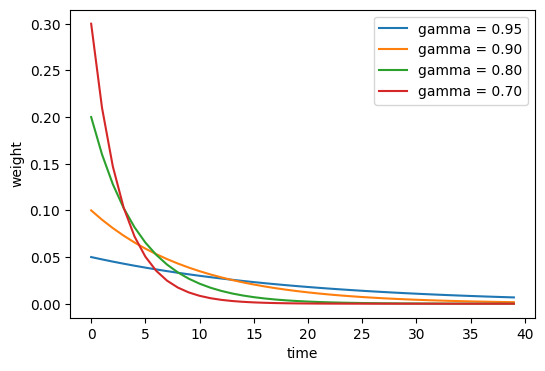

In [1]:
import torch
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(6, 4))

# 定义 gamma 值列表
gammas = [0.95, 0.9, 0.8, 0.7]

# 对每个 gamma 值计算并绘制权重衰减曲线
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    weights = (1 - gamma) * gamma ** x
    plt.plot(x, weights, label=f'gamma = {gamma:.2f}')

# 添加轴标签和图例
plt.xlabel('time')
plt.ylabel('weight')
plt.legend()

# 显示图形
plt.show()

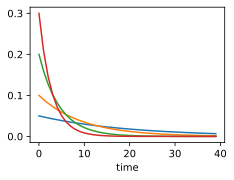

In [2]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time');

## 从零开始实现

和之前一样，我们使用二次函数$f(\mathbf{x})=0.1x_1^2+2x_2^2$来观察RMSProp算法的轨迹。
回想在 :numref:`sec_adagrad`一节中，当我们使用学习率为0.4的Adagrad算法时，变量在算法的后期阶段移动非常缓慢，因为学习率衰减太快。
RMSProp算法中不会发生这种情况，因为$\eta$是单独控制的。


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_trace_2d(f, results):
    """显示优化过程中2D变量的轨迹"""
    # 设置图形大小
    plt.figure(figsize=(6, 4))
    
    # 绘制优化轨迹
    x_coords, y_coords = zip(*results)
    plt.plot(x_coords, y_coords, '-o', color='#ff7f0e')
    
    # 创建网格点用于绘制等高线
    x1_range = torch.arange(-5.5, 1.0, 0.1)
    x2_range = torch.arange(-3.0, 1.0, 0.1)
    x1, x2 = torch.meshgrid(x1_range, x2_range, indexing='ij')
    
    # 计算目标函数值并绘制等高线
    z = f(x1, x2)
    plt.contour(x1.numpy(), x2.numpy(), z.numpy(), colors='#1f77b4')
    
    # 添加坐标轴标签
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 显示图形
    plt.tight_layout()
    plt.show()

def train_2d(trainer, steps=20, f_grad=None):  #@save
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

epoch 20, x1: -0.010599, x2: 0.000000


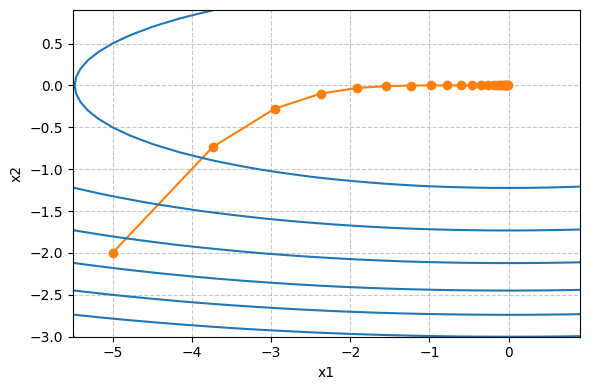

In [8]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

接下来，我们在深度网络中实现RMSProp算法。


In [9]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

In [10]:
def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

我们将初始学习率设置为0.01，加权项$\gamma$设置为0.9。
也就是说，$\mathbf{s}$累加了过去的$1/(1-\gamma) = 10$次平方梯度观测值的平均值。


In [11]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def download_file(url, filename):
    """下载文件"""
    import urllib.request
    import os
    
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
    else:
        print(f"{filename} already exists.")
    return filename

def load_array(data_arrays, batch_size, is_train=True):
    """构建PyTorch数据迭代器"""
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

# 数据集信息
DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['airfoil'] = (DATA_URL + 'airfoil_self_noise.dat',
                       '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    """
    获取空气动力学数据集
    
    参数:
    - batch_size: 批量大小
    - n: 使用的样本数量
    
    返回:
    - data_iter: 数据迭代器
    - feature_dim: 特征维度
    """
    # 下载数据
    url, sha1_hash = DATA_HUB['airfoil']
    filename = 'airfoil_self_noise.dat'
    download_file(url, filename)
    
    # 加载数据
    data = np.genfromtxt(filename, dtype=np.float32, delimiter='\t')
    
    # 数据标准化：移除均值并缩放方差为1
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    
    # 取前n个样本，特征为前几列，标签为最后一列
    features = torch.from_numpy(data[:n, :-1])
    labels = torch.from_numpy(data[:n, -1])
    
    # 创建数据加载器
    data_iter = load_array((features, labels), batch_size, is_train=True)
    
    # 返回数据迭代器和特征维度
    return data_iter, data.shape[1]-1

In [13]:
from IPython import display
import torch

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

import time
import numpy as np
import torch

class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    # 训练模型
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.245, 0.006 sec/epoch


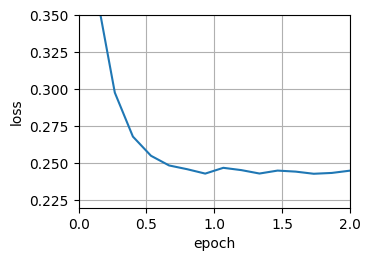

In [14]:
data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

## 简洁实现

我们可直接使用深度学习框架中提供的RMSProp算法来训练模型。


In [15]:
from torch import nn
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.245, 0.006 sec/epoch


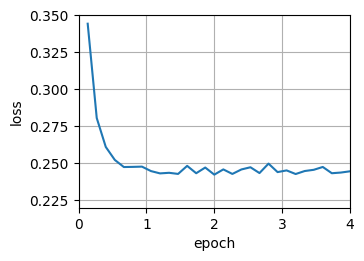

In [16]:
trainer = torch.optim.RMSprop
train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

## 小结

* RMSProp算法与Adagrad算法非常相似，因为两者都使用梯度的平方来缩放系数。
* RMSProp算法与动量法都使用泄漏平均值。但是，RMSProp算法使用该技术来调整按系数顺序的预处理器。
* 在实验中，学习率需要由实验者调度。
* 系数$\gamma$决定了在调整每坐标比例时历史记录的时长。

## 练习

1. 如果我们设置$\gamma = 1$，实验会发生什么？为什么？
1. 旋转优化问题以最小化$f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$。收敛会发生什么？
1. 试试在真正的机器学习问题上应用RMSProp算法会发生什么，例如在Fashion-MNIST上的训练。试验不同的取值来调整学习率。
1. 随着优化的进展，需要调整$\gamma$吗？RMSProp算法对此有多敏感？


[Discussions](https://discuss.d2l.ai/t/4322)
